# Отток клиентов

Цель - спрогнозировать отток клиентов банка на основе исторической информации о поведении клиентов и расторжении договоров с банком.

Описание данных:   

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import seaborn as sns

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
from sklearn.preprocessing import OrdinalEncoder

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.metrics import f1_score

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
from sklearn.utils import shuffle

In [15]:
from sklearn.metrics import recall_score, precision_score

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
from sklearn.metrics import roc_curve

In [18]:
from sklearn.metrics import roc_auc_score

##  Подготовка данных

### Загрузка данных

In [19]:
df = pd.read_csv('/datasets/Churn.csv')

In [20]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [22]:
# проверим данные на наличие дубликатов
df.duplicated().sum()
print('Количество дубликатов:', df.duplicated(subset=['Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']).sum())

Количество дубликатов: 0


In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


### Предобработка данных

Минимальное значение EstimatedSalary очень низкое, не похоже на реалистичное

In [24]:
np.percentile(df['EstimatedSalary'], [0.2, 0.5, 1, 2, 3])

array([ 468.89758,  878.78265, 1842.8253 , 3769.4488 , 5811.2985 ])

In [25]:
print('Доля низкой ЗП: ', df[df['EstimatedSalary'] < 1800]['CustomerId'].nunique() / df['CustomerId'].nunique())

Доля низкой ЗП:  0.0099


1% значений в столбце с зарплатой менее 1800 руб., заменим их на 1800 руб. как минимальное пороговое значение. 

In [26]:
df['EstimatedSalary'] = df['EstimatedSalary'].mask(df['EstimatedSalary'] < 1800, 1800)

В столбце Tenure 9 пропущенных значений, заменим их на 0.

In [27]:
df['Tenure'] = df['Tenure'].fillna(0)

Столбцы `CustomerId`, `Surname` и `RowNumber` содержат идентификационные данные о пользователе, удалим их, они уникальны и не могут быть признаками в модели 

In [28]:
df = df.drop(columns=['RowNumber', 'Surname', 'CustomerId'])

Проверим признаки на мультиколлинеарность

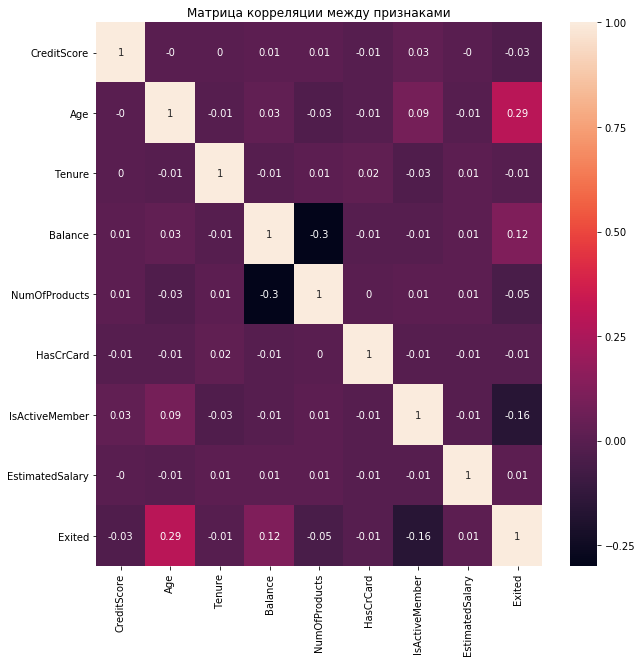

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Матрица корреляции между признаками')
sns.heatmap(df.corr().round(2), annot=True);

Высокой корреляции между признаками не обнаружено.

### Кодировка признаков, разделение на выборки, масштабирование данных

#### Преобразуем категориальные признаки в числовые техникой One-Hot Encoding для логистической регрессии

In [30]:
df_ohe = pd.get_dummies(df, drop_first=True)

#### Преобразуем категориальные признаки в числовые техникой Ordinal Encoding моделей деревьев

In [31]:
encoder = OrdinalEncoder()

In [32]:
df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

#### Разобьем данные на выборки

Сохраним признаки и целевые значения в переменные.

In [33]:
# для логистической регрессии
features_ohe = df_ohe.drop(columns=['Exited'])
target_ohe = df_ohe['Exited']

In [34]:
# для деревьев
features_ordinal = df_ordinal.drop(columns=['Exited'])
target_ordinal = df_ordinal['Exited']

Разобьем данные на обучающую, валидационную и тестовую выборки в пропорции 60% / 20% / 20%

Укажем параметр stratify для стратификации выборок при разделении. Чтобы пропорция значений в полученных выборках была такой же, как в изначальной.

Для логистической регрессии

In [35]:
# сначала разделим на обучающую 60% и валидационную 40%
features_train_ohe, features_valid_ohe, \
target_train_ohe,target_valid_ohe = train_test_split(features_ohe,target_ohe,test_size=0.4,stratify=target_ohe,
                                                     random_state=12345)
# полученную валидационную выборку разделим на валидационную и тестовую 50%/50%
features_valid_ohe, features_test_ohe,target_valid_ohe, target_test_ohe = train_test_split(features_valid_ohe,
                                                                                           target_valid_ohe,
                                                                            test_size=0.5, stratify=target_valid_ohe
                                                                                          , random_state=12345)

In [36]:
print('Размеры выборок OHE: train, valid, test', target_train_ohe.shape, target_valid_ohe.shape, target_test_ohe.shape)

Размеры выборок OHE: train, valid, test (6000,) (2000,) (2000,)


Для леса

In [37]:
# сначала разделим на обучающую 60% и валидационную 40%
features_train_ordinal, features_valid_ordinal, \
target_train_ordinal,target_valid_ordinal = train_test_split(features_ordinal,target_ordinal,test_size=0.4,
                                                                                             stratify=target_ordinal,
                                                            random_state=12345)
# полученную валидационную выборку разделим на валидационную и тестовую 50%/50%
features_valid_ordinal, features_test_ordinal,target_valid_ordinal, \
target_test_ordinal = train_test_split(features_valid_ordinal,target_valid_ordinal,
                                       test_size=0.5, stratify=target_valid_ordinal, random_state=12345)

In [38]:
print('Размеры выборок OrdinalEncoder: train, valid, test', target_train_ordinal.shape,
      target_valid_ordinal.shape, target_test_ordinal.shape)

Размеры выборок OrdinalEncoder: train, valid, test (6000,) (2000,) (2000,)


#### Масштабируем признаки методом стандартизации данных

Масштабируем все числовые признаки на обучающей, валидационной и тестовой выборках

Для логистической регрессии

In [39]:
numeric = features_train_ohe.columns

In [40]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
pd.options.mode.chained_assignment = None
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [42]:
# сбросим индексы
features_valid_ohe = features_valid_ohe.reset_index(drop=True)
features_train_ohe = features_train_ohe.reset_index(drop=True)
target_train_ohe = target_train_ohe.reset_index(drop=True)
target_valid_ohe = target_valid_ohe.reset_index(drop=True)
features_test_ohe = features_test_ohe.reset_index(drop=True)
target_test_ohe = target_test_ohe.reset_index(drop=True)

Для леса

In [43]:
numeric = features_train_ordinal.columns

In [44]:
scaler = StandardScaler()
scaler.fit(features_train_ordinal[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [45]:
pd.options.mode.chained_assignment = None
features_train_ordinal[numeric] = scaler.transform(features_train_ordinal[numeric])
features_valid_ordinal[numeric] = scaler.transform(features_valid_ordinal[numeric])
features_test_ordinal[numeric] = scaler.transform(features_test_ordinal[numeric])

In [46]:
# сбросим индексы
features_train_ordinal = features_train_ordinal.reset_index(drop=True)
features_valid_ordinal = features_valid_ordinal.reset_index(drop=True)
target_train_ordinal = target_train_ordinal.reset_index(drop=True)
target_valid_ordinal = target_valid_ordinal.reset_index(drop=True)
features_test_ordinal = features_test_ordinal.reset_index(drop=True)
target_test_ordinal = target_test_ordinal.reset_index(drop=True)

### Вывод.  
Таблица с данными содержит 14 столбцов и 10000 строк.  
Высокой коррелции между признаками не обнаружено.  
Заменили пропущенное значение в столбце Tenure на 0, так как предполагаем, если значение пропущено, то у клиента нет недвижимости.  
Удалили столбцы `CustomerId`, `Surname` и `RowNumber`, так как они содержат уникальные идентификационные данные о пользователе.  
Заменили значения менее 1800 руб. (1% от выборки имеет значение до 1800) в столбце EstimatedSalary на 1800 руб. как минимально допустимое.    
Преобразовали категориальные признаки техникой OHE.  
После преобразований у нас получилось 11 столбцов с признаками и 1 целевая переменная.  
Разделили выборку на:
- обучающую 60%, 6000 строк, 
- валидационную 20%, 2000 строк,
- тестовую 20%, 2000 строк.  

Масшабировали числовые признаки.

## Исследование задачи

### Исследуем баланс классов

Посмотрим на распределение классов в целевой переменной

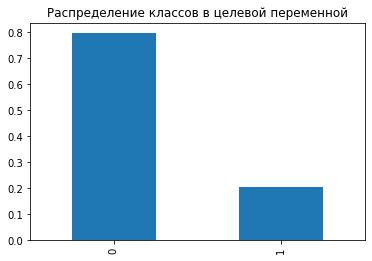

In [47]:
df['Exited'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение классов в целевой переменной');

20% значений целевой переменной соответствует 1, а 80% значений 0. В данных наблюдается явный дисбаланс.

### Изучим модели без учета дисбаланса

#### LogisticRegression без учета дисбаланса (выборка несбалансирована)

In [48]:
model_L = LogisticRegression(random_state=12345, solver='liblinear')
model_L.fit(features_train_ohe, target_train_ohe)
predicted_L_valid = model_L.predict(features_valid_ohe)
print("F1:", f1_score(target_valid_ohe, predicted_L_valid))

F1: 0.3076923076923077


Построим матрицу ошибок

In [49]:
confusion_matrix(target_valid_ohe, predicted_L_valid)

array([[1538,   54],
       [ 324,   84]])

Метрика F1 на валидационной выборке 0.31, это низкий показатель.
- TN 1538 ответов
- FP 54 ответа
- FN 324 ответа
- TP 84 ответа  

Модель пессимистична

#### RandomForestClassifier без учета дисбаланса (выборка несбалансирована)

Подберем глубину деревьев

In [50]:
best_model_R = None
best_result_R = 0
for depth in range(1, 31):
    #обучим модель на валидационной выборке
    model_R = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=10)
    model_R.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 наилучшей модели на валидационной выборке: 0.6026200873362445
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Выберем глубину деревьев = 15

Подберем количество деревьев при глубине 15

In [51]:
best_model_R = None
best_result_R = 0
for est in range(1, 70):
    model_R = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=15)
    #обучим модель на тренировочной выборке
    model_R.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6056129985228951
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Лучшее значение F1 при количестве деревьев = 16

Построим матрицу ошибок

In [52]:
confusion_matrix(target_valid_ordinal, predicted_R_valid)

array([[1537,   55],
       [ 215,  193]])

Метрика F1 на валидационной выборке 0.61, это достаточно высокий показатель.
- TN 1537 ответов
- FP 55 ответа
- FN 215 ответа
- TP 193 ответа  

Модель RandomForestClassifier прогнозирует эффективнее, чем LogisticRegression

#### DecisionTreeClassifier без учета дисбаланса (выборка несбалансирована)

In [53]:
best_model_D = None
best_result_D = 0
for depth in range(1, 31):
    model_D = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_D.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_D_valid = model_D.predict(features_valid_ordinal)
    # посчитаем F1 
    result_D = f1_score(target_valid_ordinal, predicted_D_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_D > best_result_D:
        best_model_D = model_D
        best_result_D = result_D
print('F1 наилучшей модели на валидационной выборке:', best_result_D)
print('Описание модели: ' , best_model_D)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 наилучшей модели на валидационной выборке: 0.5951359084406294
Описание модели:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')


F1 на DecisionTreeClassifier получился 0.595, это достаточно хорошо.  
Глубина дерева 8.

Построим матрицу ошибок

In [54]:
confusion_matrix(target_valid_ordinal, predicted_D_valid)

array([[1377,  215],
       [ 186,  222]])

Метрика F1 на валидационной выборке 0.595, это достаточно высокий показатель.
- TN 1377 ответов
- FP 215 ответа
- FN 186 ответа
- TP 222 ответа  

Модель DecisionTreeClassifier на 97% неверно прогнозирует целевое значение равное 1. Это плохой результат.

### Вывод.  
- 20% значений целевой переменной соответствует 1, а 80% значений 0. В данных наблюдается явный дисбаланс
- Метрика F1 у разных моделей на несбалансированных выборках:
    - LogisticRegression 0.30769
    - RandomForestClassifier 0.60561, при глубине деревьев 15, количестве деревьев 16
    - DecisionTreeClassifier 0.59513, при при глубине дерева 8
- Матрица ошибок моделей LogisticRegression и DecisionTreeClassifier очень пессиместична, а модели RandomForestClassifier достаточно оптимистична

## Борьба с дисбалансом

### Взвешивание классов

#### LogisticRegression

In [55]:
model_L = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_L.fit(features_train_ohe, target_train_ohe)
predicted_L_valid = model_L.predict(features_valid_ohe)
print("F1:", f1_score(target_valid_ohe, predicted_L_valid))

F1: 0.5285338015803336


Метрика улучшилась. Построим матрицу ошибок.

In [56]:
confusion_matrix(target_valid_ohe, predicted_L_valid)

array([[1162,  430],
       [ 107,  301]])

Метрика F1 на валидационной выборке 0.53, но это низкий показатель.
- TN 1162 ответов
- FP 430 ответа
- FN 107 ответа
- TP 301 ответа  

#### RandomForestClassifier

Подберем глубину деревьев

In [57]:
best_model_R = None
best_result_R = 0
for depth in range(1, 31):
    #обучим модель на валидационной выборке
    model_R = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=10, class_weight='balanced')
    model_R.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6252676659528907
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)


Выберем глубину деревьев = 8, подберем количество деревьев при этой

In [58]:
best_model_R = None
best_result_R = 0
for est in range(1, 70):
    model_R = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=8, class_weight='balanced')
    #обучим модель на тренировочной выборке
    model_R.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6464864864864864
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=67, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)


Лучшее значение F1 при количестве деревьев = 67. Метрика F1 достаточно высокая.

Построим матрицу ошибок

In [59]:
confusion_matrix(target_valid_ordinal, predicted_R_valid)

array([[1371,  221],
       [ 111,  297]])

Метрика F1 на валидационной выборке 0.65, это достаточно высокий показатель.
- TN 1371 ответов
- FP 221 ответа
- FN 111 ответа
- TP 297 ответа  

Модель RandomForestClassifier прогнозирует эффективнее, чем LogisticRegression

#### DecisionTreeClassifier без учета дисбаланса (выборка несбалансирована)

In [60]:
best_model_D = None
best_result_D = 0
for depth in range(1, 31):
    model_D = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_D.fit(features_train_ordinal, target_train_ordinal)
    # предскажем целевую переменную на валидационной выборке
    predicted_D_valid = model_D.predict(features_valid_ordinal)
    # посчитаем F1 
    result_D = f1_score(target_valid_ordinal, predicted_D_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_D > best_result_D:
        best_model_D = model_D
        best_result_D = result_D
print('F1 наилучшей модели на валидационной выборке:', best_result_D)
print('Описание модели: ' , best_model_D)

F1 наилучшей модели на валидационной выборке: 0.5884578997161779
Описание модели:  DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')


F1 на DecisionTreeClassifier получился 0.589, это достаточно хорошо, но хуже, чем у модели RandomForestClassifier.
Глубина дерева 7.

Построим матрицу ошибок

In [61]:
confusion_matrix(target_valid_ordinal, predicted_D_valid)

array([[1379,  213],
       [ 201,  207]])

### Upsampling

#### Выборка с upsampling

Посчитаем отношение класса 1 и 0 в выборке, чтобы задать правильный множитель (repeat)

In [62]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [63]:
print('Коэффициент repeat:', (df['Exited'].value_counts()[0] / df['Exited'].value_counts()[1]).round(1))

Коэффициент repeat: 3.9


Функция для увеличения выборки

In [64]:
def upsample(features, target, repeat):
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # cкопируем несколько раз положительные объекты и создадим новую обучающую выборку
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешаем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Увеличим выборку с целевым значением 1 в 4 раза для ohe

In [65]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train_ohe, 4)

#### LogisticRegression

In [66]:
model_L = LogisticRegression(solver='liblinear', random_state=12345) 
model_L.fit(features_upsampled, target_upsampled)
predict_L = model_L.predict(features_valid_ohe)

In [67]:
print('F1: ', f1_score(target_valid_ohe, predict_L))

F1:  0.5246753246753246


F1 не изменился после приведения выборки к сбалансированному виду.

#### RandomForestClassifier

Увеличим выборку с целевым значением 1 в 4 раза для ordinal

In [68]:
features_upsampled, target_upsampled = upsample(features_train_ordinal, target_train_ordinal, 4)

Подберем глубину деревьев

In [69]:
best_model_R = None
best_result_R = 0
for depth in range(1, 31):
    #обучим модель на валидационной выборке
    model_R = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=10)
    model_R.fit(features_upsampled, target_upsampled)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6221719457013575
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Выберем глубину деревьев = 12, подберем количество деревьев при этой глубине

In [70]:
best_model_R = None
best_result_R = 0
for est in range(1, 70):
    model_R = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=12)
    #обучим модель на тренировочной выборке
    model_R.fit(features_upsampled, target_upsampled)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6341463414634145
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=65,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Лучшее значение F1 при количестве деревьев = 39. Метрика F1 ниже, чем у этой же модели, но без upsampling

#### DecisionTreeClassifier

In [71]:
best_model_D = None
best_result_D = 0
for depth in range(1, 31):
    model_D = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_D.fit(features_upsampled, target_upsampled)
    # предскажем целевую переменную на валидационной выборке
    predicted_D_valid = model_D.predict(features_valid_ordinal)
    # посчитаем F1 
    result_D = f1_score(target_valid_ordinal, predicted_D_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_D > best_result_D:
        best_model_D = model_D
        best_result_D = result_D
print('F1 наилучшей модели на валидационной выборке:', best_result_D)
print('Описание модели: ' , best_model_D)

F1 наилучшей модели на валидационной выборке: 0.5798165137614679
Описание модели:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')


F1 на DecisionTreeClassifier получился 0.58, это хуже, чем у модели RandomForestClassifier. И хуже, чем у тойже модели без upsampling.
Глубина дерева 7.

### Downsampling

#### Выборка с downsampling

Посчитаем отношение класса 1 и 0 в выборке, чтобы задать правильный множитель (fraction)

In [72]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [73]:
print('Коэффициент fraction:', (df['Exited'].value_counts()[1] / df['Exited'].value_counts()[0]).round(2))

Коэффициент fraction: 0.26


In [74]:
#сохраним его в переменную
fraction = df['Exited'].value_counts()[1] / df['Exited'].value_counts()[0].round(2)

Напишем функцию для уменьшени выборки

In [75]:
def downsample(features, target, fraction):
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # случайным образом отбросим часть из отрицательных объектов и создадим новую выборку
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    # перемешаем данные
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Уменьшим выборку с целевым значением 0 на 0.74 для ohe

In [76]:
features_downsample, target_downsample = downsample(features_train_ohe, target_train_ohe, fraction = fraction)

In [77]:
#проверим размер полученных выборок
print(features_downsample.shape)

(2444, 11)


#### LogisticRegression

In [78]:
model_L = LogisticRegression(solver='liblinear', random_state=12345) 
model_L.fit(features_downsample, target_downsample)
predict_L = model_L.predict(features_valid_ohe)

In [79]:
print('F1: ', f1_score(target_valid_ohe, predict_L))

F1:  0.5274151436031331


F1 не изменился после приведения выборки к сбалансированному виду.

#### RandomForestClassifier

Уменьшим выборку с целевым значением 0 на 0.74 для ordinal

In [80]:
features_downsample, target_downsample = downsample(features_train_ordinal,
                                                    target_train_ordinal, fraction = fraction)

Подберем глубину деревьев

In [81]:
best_model_R = None
best_result_R = 0
for depth in range(1, 31):
    #обучим модель на валидационной выборке
    model_R = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=10)
    model_R.fit(features_downsample, target_downsample)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.601489757914339
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Выберем глубину деревьев = 6, подберем количество деревьев при этой глубине

In [82]:
best_model_R = None
best_result_R = 0
for est in range(1, 70):
    model_R = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=6)
    #обучим модель на тренировочной выборке
    model_R.fit(features_downsample, target_downsample)
    # предскажем целевую переменную на валидационной выборке
    predicted_R_valid = model_R.predict(features_valid_ordinal)
    # посчитаем F1 
    result_R = f1_score(target_valid_ordinal, predicted_R_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_R > best_result_R:
        best_model_R = model_R
        best_result_R = result_R
print('F1 наилучшей модели на валидационной выборке:', best_result_R)
print('Описание модели: ' , best_model_R)

F1 наилучшей модели на валидационной выборке: 0.6222222222222222
Описание модели:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Лучшее значение F1 при количестве деревьев = 30. Метрика F1 ниже, чем у этой же модели, но без downsampling

#### DecisionTreeClassifier

In [83]:
best_model_D = None
best_result_D = 0
for depth in range(1, 31):
    model_D = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_D.fit(features_downsample, target_downsample )
    # предскажем целевую переменную на валидационной выборке
    predicted_D_valid = model_D.predict(features_valid_ordinal)
    # посчитаем F1 
    result_D = f1_score(target_valid_ordinal, predicted_D_valid)
    #выберем глубину деревьев с максимальным F1 
    if result_D > best_result_D:
        best_model_D = model_D
        best_result_D = result_D
print('F1 наилучшей модели на валидационной выборке:', best_result_D)
print('Описание модели: ' , best_model_D)

F1 наилучшей модели на валидационной выборке: 0.5687121866897148
Описание модели:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')


F1 на DecisionTreeClassifier получился 0.57, это хуже, чем у модели RandomForestClassifier. И хуже, чем у той же модели без downsampling.
Глубина дерева 7.

### Изменение порога

#### LogisticRegression

In [84]:
model_L = LogisticRegression(solver='liblinear', random_state=12345) 
model_L.fit(features_train_ohe, target_train_ohe)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Найдем значения вероятностей классов для валидационной выборки

In [85]:
probabilities_valid = model_L.predict_proba(features_valid_ohe)
#вероятность класса 1 содержится во 2 столбце, оставим только его
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_valid

array([[0.48389307, 0.51610693],
       [0.74763961, 0.25236039],
       [0.74006008, 0.25993992],
       ...,
       [0.93261669, 0.06738331],
       [0.91337072, 0.08662928],
       [0.86452894, 0.13547106]])

Посмотрим на распределение вероятностей получить 1

In [86]:
probabilities_one_valid_DF = pd.DataFrame(data = probabilities_one_valid)

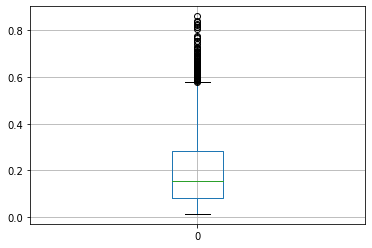

In [87]:
probabilities_one_valid_DF.boxplot();

In [88]:
probabilities_one_valid_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2000.0,0.204674,0.162015,0.013871,0.081709,0.154269,0.281324,0.860506


75% значений имеют вероятность быть 1 не более 28%. Подберем значение порога в диапазоне 0.1 до 0.35 с шагом 0.02

In [89]:
for threshold in np.arange(0.1, 0.35, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_ohe, predicted_valid)
    recall = recall_score(target_valid_ohe, predicted_valid)
    f1 = f1_score(target_valid_ohe, predicted_valid)
    print("Порог = {:.2f} Точность = {:.3f} Полнота = {:.3f} F1 = {:.3f}".format(threshold, precision, recall, f1)) 

Порог = 0.10 Точность = 0.277 Полнота = 0.929 F1 = 0.427
Порог = 0.12 Точность = 0.296 Полнота = 0.897 F1 = 0.446
Порог = 0.14 Точность = 0.318 Полнота = 0.855 F1 = 0.464
Порог = 0.16 Точность = 0.351 Полнота = 0.828 F1 = 0.493
Порог = 0.18 Точность = 0.371 Полнота = 0.772 F1 = 0.501
Порог = 0.20 Точность = 0.387 Полнота = 0.733 F1 = 0.506
Порог = 0.22 Точность = 0.415 Полнота = 0.708 F1 = 0.524
Порог = 0.24 Точность = 0.432 Полнота = 0.669 F1 = 0.525
Порог = 0.26 Точность = 0.449 Полнота = 0.620 F1 = 0.521
Порог = 0.28 Точность = 0.474 Полнота = 0.583 F1 = 0.523
Порог = 0.30 Точность = 0.481 Полнота = 0.532 F1 = 0.505
Порог = 0.32 Точность = 0.494 Полнота = 0.478 F1 = 0.486
Порог = 0.34 Точность = 0.507 Полнота = 0.434 F1 = 0.468


Модель будет показывать лучший результат, если снизить порог с 0.5 до 0.3

#### RandomForestClassifier

Глубину и количество деревьев укажем как в модели при Взвешивании классов. Глубина 8, 67 деревьев.

In [90]:
model_R = RandomForestClassifier(random_state=12345, max_depth = 8, n_estimators=67, class_weight='balanced')
model_R.fit(features_train_ordinal, target_train_ordinal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=67, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

Найдем значения вероятностей классов для валидационной выборки

In [91]:
probabilities_valid = model_R.predict_proba(features_valid_ordinal)
#вероятность класса 1 содержится во 2 столбце, оставим только его
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_valid

array([[0.36268748, 0.63731252],
       [0.53041492, 0.46958508],
       [0.61757112, 0.38242888],
       ...,
       [0.73040729, 0.26959271],
       [0.87110587, 0.12889413],
       [0.83581349, 0.16418651]])

Посмотрим на распределение вероятностей получить 1

In [92]:
probabilities_one_valid_DF = pd.DataFrame(data = probabilities_one_valid)

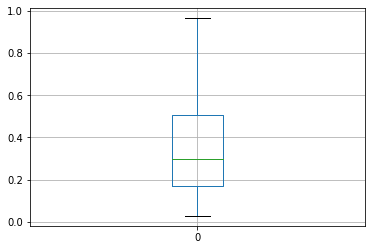

In [93]:
probabilities_one_valid_DF.boxplot();

In [94]:
probabilities_one_valid_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2000.0,0.361138,0.237745,0.028498,0.172006,0.298505,0.506668,0.964136


75% значений имеют вероятность быть 1 не более 51%. Подберем значение порога в диапазоне 0.1 до 0.55 с шагом 0.02

In [95]:
for threshold in np.arange(0.1, 0.65, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_ordinal, predicted_valid)
    recall = recall_score(target_valid_ohe, predicted_valid)
    f1 = f1_score(target_valid_ohe, predicted_valid)
    print("Порог = {:.2f} Точность = {:.3f} Полнота = {:.3f} F1 = {:.3f}".format(threshold, precision, recall, f1)) 

Порог = 0.10 Точность = 0.228 Полнота = 0.995 F1 = 0.371
Порог = 0.12 Точность = 0.238 Полнота = 0.990 F1 = 0.383
Порог = 0.14 Точность = 0.249 Полнота = 0.988 F1 = 0.398
Порог = 0.16 Точность = 0.258 Полнота = 0.975 F1 = 0.408
Порог = 0.18 Точность = 0.269 Полнота = 0.973 F1 = 0.422
Порог = 0.20 Точность = 0.281 Полнота = 0.966 F1 = 0.436
Порог = 0.22 Точность = 0.291 Полнота = 0.949 F1 = 0.445
Порог = 0.24 Точность = 0.311 Полнота = 0.939 F1 = 0.467
Порог = 0.26 Точность = 0.327 Полнота = 0.924 F1 = 0.483
Порог = 0.28 Точность = 0.346 Полнота = 0.907 F1 = 0.501
Порог = 0.30 Точность = 0.369 Полнота = 0.902 F1 = 0.524
Порог = 0.32 Точность = 0.388 Полнота = 0.890 F1 = 0.541
Порог = 0.34 Точность = 0.410 Полнота = 0.877 F1 = 0.559
Порог = 0.36 Точность = 0.435 Полнота = 0.865 F1 = 0.579
Порог = 0.38 Точность = 0.450 Полнота = 0.843 F1 = 0.587
Порог = 0.40 Точность = 0.469 Полнота = 0.826 F1 = 0.599
Порог = 0.42 Точность = 0.487 Полнота = 0.809 F1 = 0.608
Порог = 0.44 Точность = 0.512 П

Самый оптимальный порог 0.5

#### DecisionTreeClassifier

Глубину деревьев укажем как в модели при Взвешивании классов. Глубина 7.

In [96]:
model_D = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced')
model_D.fit(features_train_ordinal, target_train_ordinal)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Найдем значения вероятностей классов для валидационной выборки

In [97]:
probabilities_valid = model_D.predict_proba(features_valid_ordinal)
#вероятность класса 1 содержится во 2 столбце, оставим только его
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_valid

array([[0.45300217, 0.54699783],
       [0.45300217, 0.54699783],
       [0.70271728, 0.29728272],
       ...,
       [0.91341929, 0.08658071],
       [0.78665039, 0.21334961],
       [0.78665039, 0.21334961]])

Посмотрим на распределение вероятностей получить 1

In [98]:
probabilities_one_valid_DF = pd.DataFrame(data = probabilities_one_valid)

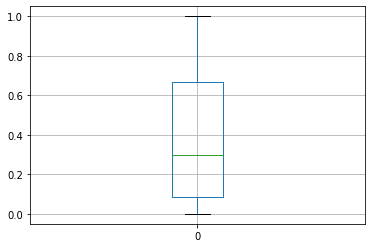

In [99]:
probabilities_one_valid_DF.boxplot();

In [100]:
probabilities_one_valid_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2000.0,0.368215,0.314866,0.0,0.086581,0.297283,0.66773,1.0


75% значений имеют вероятность быть 1 не более 67%. Подберем значение порога в диапазоне 0.1 до 0.70 с шагом 0.02

In [101]:
for threshold in np.arange(0.1, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_ordinal, predicted_valid)
    recall = recall_score(target_valid_ohe, predicted_valid)
    f1 = f1_score(target_valid_ohe, predicted_valid)
    print("Порог = {:.2f} Точность = {:.3f} Полнота = {:.3f} F1 = {:.3f}".format(threshold, precision, recall, f1))   

Порог = 0.10 Точность = 0.254 Полнота = 0.919 F1 = 0.397
Порог = 0.12 Точность = 0.264 Полнота = 0.914 F1 = 0.409
Порог = 0.14 Точность = 0.281 Полнота = 0.900 F1 = 0.428
Порог = 0.16 Точность = 0.281 Полнота = 0.900 F1 = 0.428
Порог = 0.18 Точность = 0.292 Полнота = 0.890 F1 = 0.439
Порог = 0.20 Точность = 0.297 Полнота = 0.885 F1 = 0.445
Порог = 0.22 Точность = 0.325 Полнота = 0.848 F1 = 0.470
Порог = 0.24 Точность = 0.335 Полнота = 0.846 F1 = 0.479
Порог = 0.26 Точность = 0.335 Полнота = 0.846 F1 = 0.479
Порог = 0.28 Точность = 0.335 Полнота = 0.846 F1 = 0.479
Порог = 0.30 Точность = 0.376 Полнота = 0.841 F1 = 0.519
Порог = 0.32 Точность = 0.376 Полнота = 0.841 F1 = 0.519
Порог = 0.34 Точность = 0.376 Полнота = 0.841 F1 = 0.519
Порог = 0.36 Точность = 0.397 Полнота = 0.824 F1 = 0.536
Порог = 0.38 Точность = 0.415 Полнота = 0.794 F1 = 0.545
Порог = 0.40 Точность = 0.433 Полнота = 0.789 F1 = 0.559
Порог = 0.42 Точность = 0.445 Полнота = 0.779 F1 = 0.567
Порог = 0.44 Точность = 0.445 П

Оптимальный порог 0.56

### Вывод  
Для борьбы с дисбалансом были использованы техники:
- Взвешивание классов
- Upsampling
- Downsampling
- Изменение порога
Без учета дисбаланса лучший результат получила модель RandomForestClassifier f1 = 0.60561.
После борьбы с дисбалансом значение метрики f1 модели RandomForestClassifier изменилось:
- Взвешивание классов f1 = 0.64648. Глубина 8, количество деревьев 67  
- Upsampling f1 = 0.6341. Глубина 12, количество деревьев 39
- Downsampling f1 = 0.6222. Глубина 6, количество деревьев 30
- При пороге = 0.5, f1 = 0.625. Глубина 8, количество деревьев 67  
Итого лучшая модель:  
RandomForestClassifier с параметром class_weight='balanced', f1 = 0.64648. Глубина 8, количество деревьев 67.

### Тестирование модели

#### Тестирование RandomForestClassifier

Протестируем модель RandomForestClassifier с параметром class_weight='balanced', f1 = 0.64648. Глубина 8, количество деревьев 67. С балансировкой классов.

In [102]:
model_R = RandomForestClassifier(random_state=12345, n_estimators=67, max_depth=8, class_weight='balanced')
model_R.fit(features_train_ordinal, target_train_ordinal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=67, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [103]:
predictions_test = model_R.predict(features_test_ordinal)

In [104]:
result_R = f1_score(target_test_ordinal, predictions_test)
print('F1: ', result_R)

F1:  0.60734149054505


Метрика F1 достаточно высокая, 0.607

#### Проверим модель на адекватность

Посчитаем долю классов в целевом признаке на тестовой выборке

In [105]:
target_test_ordinal_S = pd.Series(target_test_ordinal)
target_test_ordinal_S.value_counts(normalize=True)

0.0    0.7965
1.0    0.2035
Name: Exited, dtype: float64

Посчитаем долю классов в предсказанной модели на тестовой выборке

In [106]:
predictions_test_S = pd.Series(predictions_test)
predictions_test_S.value_counts(normalize=True)

0.0    0.754
1.0    0.246
dtype: float64

Распределение значений целевых переменных похоже, значит модель адекватна.

Сравним долю правильных ответов полученной модели с моделью, прогнозирующей медианное значение

Посчитаем долю правильных ответов (accuracy_score) в предсказанной модели на тестовой выборке 

In [107]:
print('accuracy', accuracy_score(target_test_ordinal, predictions_test))

accuracy 0.8235


In [108]:
# модель, прогнозирующая медианное значение
target_pred_constant = pd.Series(target_test_ordinal.median(), index=target_test_ordinal.index)

In [109]:
print('accuracy константной модели', accuracy_score(target_test_ordinal, target_pred_constant))

accuracy константной модели 0.7965


accuracy предсказанной модели выше, чем константной, значит модель адекватна

#### AUC-ROC (площадь под кривой ошибок)

In [110]:
probabilities_test = model_R.predict_proba(features_test_ordinal)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test_ordinal, probabilities_one_test) 

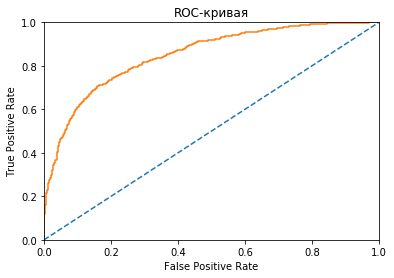

In [111]:
plt.figure()
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
# ROC-кривая тестовой модели
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [112]:
auc_roc = roc_auc_score(target_test_ordinal, probabilities_one_test)
print('Площадь под кривой ROC', auc_roc)

Площадь под кривой ROC 0.8498699007173584


Показатель метрики достаточно высокий, модель дает большую долю верных позитивных ответов.

### Вывод.  
Тестовая модель (RandomForestClassifier с параметром class_weight='balanced', f1 = 0.64648. Глубина 8, количество деревьев 67) дала результат метрики F1 = 0.607. Этот результат соответствует целевому.  
Считаем, что модель адекватна. Проверили адекватность модели:  
- Распределение значений реальных и предсказанных целевых переменных примерно похожи
- accuracy предсказанной модели выше, чем константной  

Значение метрики AUC_ROC достаточно высокий, значит модель дает большую долю верных позитивных ответов.